## Methods to compare in integration tasks

Harmony and Liger are widely-used data integration / batch effect correction methods that have Python implementations. Harmony is usually considered to be less aggressive in strength, thus keeping more biological variance. Liger is suitable in situations with more severe batch effect.

In [1]:
import scanpy as sc
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
# Some utilities does not work on Windows. Consider using WSL2 on a Windows machine.
# Known probablematic ones: scib.me.clisi_graph
import scib

In [3]:
from tqdm import tqdm

In [4]:
import matplotlib as mpl

## Load data and view the data without integration

In [5]:
adata = sc.read_h5ad('output/mouse-brain-374-integration.h5ad')

In [6]:
with open("output/mouse-brain-374-kuanglu-emb.pkl", 'rb') as f:
    adata.obsm['X_kuanglu'] = pkl.load(f)

## Scoring and plotting 

In [7]:
adata.obs.columns

Index(['fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y',
       'age', 'clust_annot', 'slice', 'organism_ontology_term_id',
       'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id',
       'assay_ontology_term_id', 'tissue_ontology_term_id',
       'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'donor_id', 'is_primary_data',
       'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex',
       'tissue', 'self_reported_ethnicity', 'development_stage',
       'donor_slice'],
      dtype='object')

In [8]:
batch = 'donor_slice'
label = 'cell_type'

In [9]:
ct = pd.crosstab(adata.obs[label], adata.obs[batch])
abundant_cell_types = ct.index[ct.min(axis=1) >= 3].tolist()
print(*abundant_cell_types, sep=', ')

endothelial cell, astrocyte, oligodendrocyte, microglial cell, macrophage, inhibitory interneuron, neuron, pericyte, oligodendrocyte precursor cell, medium spiny neuron, vascular leptomeningeal cell


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


In [10]:
adata = adata[adata.obs[label].isin(abundant_cell_types)]

/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [11]:
methods = ('liger', 'harmony', 'pca', 'scanorama', 'kuanglu')
use_cosine = ['liger', 'scanorama']

In [13]:
scores = {}

for method in tqdm(methods):
    matrix_name = 'X_' + method
    print(method, end='')
    s = skl.metrics.silhouette_score(adata.obsm[matrix_name], adata.obs[label])
    print('.', end='')
    db = skl.metrics.davies_bouldin_score(adata.obsm[matrix_name], adata.obs[label])
    print('.', end='')
    ch = skl.metrics.calinski_harabasz_score(adata.obsm[matrix_name], adata.obs[label])
    print('.')
    
    scores[method] = [s, db, ch]

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

liger..

 20%|████████████████▏                                                                | 1/5 [21:49<1:27:18, 1309.61s/it]

.
harmony.

 40%|████████████████████████████████▍                                                | 2/5 [52:32<1:21:10, 1623.35s/it]

..
pca.

 60%|███████████████████████████████████████████████▍                               | 3/5 [1:33:33<1:06:51, 2005.97s/it]

..
scanorama..

 80%|████████████████████████████████████████████████████████████████▊                | 4/5 [1:57:27<29:40, 1780.12s/it]

.
kuanglu..

100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [2:22:01<00:00, 1704.31s/it]

.


In [14]:
scores = pd.DataFrame(scores, index=['silhouette', 'davies_bouldin', 'calinski_harabasz']).T

In [15]:
scores = scores.loc[['kuanglu', 'scanorama', 'harmony', 'liger', 'pca']]
scores

,silhouette,davies_bouldin,calinski_harabasz
kuanglu,0.390646,1.555842,81715.920578
scanorama,0.371150,2.048746,64322.661638
harmony,0.277262,1.642676,44776.562436
liger,0.310450,1.599514,48785.303650
pca,0.252160,1.731469,38883.075352


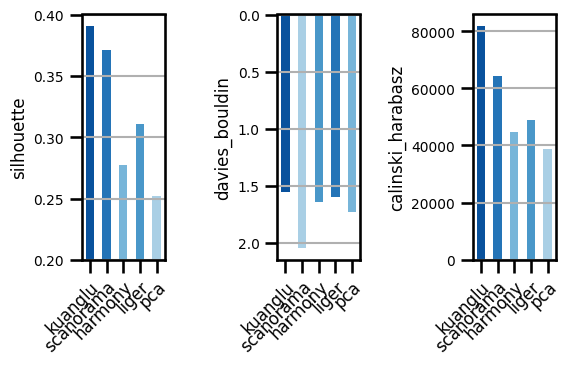

In [16]:
cmap = mpl.colormaps['Blues']
lower_is_better = ['davies_bouldin']
plt.subplots(1, scores.shape[1], figsize=(6, 4))
for i, v in enumerate(scores.columns):
    plt.subplot(1, scores.shape[1], i + 1)
    color = mpl.colormaps['Blues'](1 - scores[v].rank(ascending=v in lower_is_better, pct=True) * .66)
    scores[v].plot(kind='bar', color=color)
    plt.ylabel(v, size=12)
    plt.grid(axis='y')
    plt.yticks(size=10)
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor', size=12)
    
    dmin = scores[v].min()
    dmax = scores[v].max()
    
    if dmin >= 0.0 and dmin <= 1.0 and dmax >= 0.0 and dmax <= 1.0:
        for vmin in [0.99, 0.8, 0.6, 0.4, 0.2, 0.0]:
            if dmin > vmin:
                break
        for vmax in [0.2, 0.4, 0.6, 0.8, 1.0]:
            if dmax < vmax:
                break
        plt.ylim(vmin, vmax)
        
    if v in lower_is_better:
        plt.gca().invert_yaxis()
    
plt.tight_layout()

In [ ]:
batch_scores = {}


for method in tqdm(methods):
    matrix_name = 'X_' + method
    
    if method in use_cosine:
        sc.pp.neighbors(adata, use_rep=matrix_name, metric='cosine')
    else:
        sc.pp.neighbors(adata, use_rep=matrix_name)
    
    sb = scib.me.silhouette_batch(adata, batch_key=batch, label_key=label, embed=matrix_name)
        
    gcb = scib.me.graph_connectivity(adata, label_key=label)
    
    ilisi = scib.me.ilisi_graph(adata, batch_key=batch, type_="knn")
    
    # kbet = scib.me.kBET(adata, batch_key=batch, label_key=label, type_="embed", embed=matrix_name)
    
    batch_scores[method] = [sb, gcb, ilisi]

In [ ]:
batch_scores = pd.DataFrame(batch_scores, index=['silhouette_batch', 'graph_connectivity_batch', 'ilisi']).T

In [ ]:
batch_scores = batch_scores.loc[['kuanglu', 'scanorama', 'harmony', 'liger', 'pca']]
batch_scores

In [ ]:
lower_is_better = [] # ['silhouette_batch', 'graph_connectivity_batch', 'ilisi']

plt.subplots(1, batch_scores.shape[1], figsize=(6, 4))
for i, v in enumerate(batch_scores.columns):
    plt.subplot(1, batch_scores.shape[1], i + 1)
    color = mpl.colormaps['Blues'](1 - batch_scores[v].rank(ascending=v in lower_is_better, pct=True) * .66)
    batch_scores[v].plot(kind='bar', color=color)
    plt.ylabel(v, size=12)
    plt.grid(axis='y')
    plt.yticks(size=10)
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor', size=12)
    
    dmin = batch_scores[v].min()
    dmax = batch_scores[v].max()
    
    if dmin >= 0.0 and dmin <= 1.0 and dmax >= 0.0 and dmax <= 1.0:
        for vmin in [0.8, 0.6, 0.4, 0.2, 0.0]:
            if dmin > vmin:
                break
        for vmax in [0.2, 0.4, 0.6, 0.8, 1.0]:
            if dmax < vmax:
                break
        plt.ylim(vmin, vmax)
    
plt.tight_layout()

In [ ]:
with open("output/mouse-brain-374-judge.pkl", 'wb') as f:
    pkl.dump([scores, batch_scores], f)